 ## بسم الله الرّحمٰن الرّحيم 

# Theory of Concentrism in the Qur'an using Genetic Algorithm with CL-AraBERT Embeddings

_by Al-Ahmadgaid B. Asaad_

#### Install Python Libraries

There are Julia's equivalent for the following Python libraries, but for this paper the author decided to use the official one which is in Python.

In [1]:
using Pkg

ENV["PYTHON"]="" # necessary for Conda.pip
Pkg.build("PyCall")

    Building Conda ─→ `~/.julia/scratchspaces/44cfe95a-1eb2-52ea-b672-e2afdf69b78f/b19db3927f0db4151cb86d073689f2428e524576/build.log`
    Building PyCall → `~/.julia/scratchspaces/44cfe95a-1eb2-52ea-b672-e2afdf69b78f/9816a3826b0ebf49ab4926e2b18842ad8b5c8f04/build.log`


In [2]:
using Conda

Conda.pip_interop(true)
Conda.pip("install", "sentence-transformers")
Conda.pip("install", "umap-learn")

[ Info: Running `conda config --set pip_interop_enabled true --file /Users/al-ahmadgaidasaad/.julia/conda/3/aarch64/condarc-julia.yml` in root environment
[ Info: Running `pip install sentence-transformers` in root environment


[ Info: Running `pip install umap-learn` in root environment


#### Load Libraries

In [3]:
using CairoMakie
using Clustering
using DataFrames
using Distributions
using Distances
using PyCall
using QuranTree
using Statistics
using Yunir

import Base: show
import StatsBase: sample

In [4]:
# load the python libraries
sentence_transformers = pyimport("sentence_transformers")
umap_py = pyimport("umap.umap_")
UMAP = umap_py.UMAP

PyObject <class 'umap.umap_.UMAP'>

#### Load CL-Arabert Embedding Model

In [5]:
model_path = "/Users/al-ahmadgaidasaad/Documents/School/Islamic Studies/ma-thesis-codes/models/CL-Arabert"
emodel = sentence_transformers.SentenceTransformer(model_path);

No sentence-transformers model found with name /Users/al-ahmadgaidasaad/Documents/School/Islamic Studies/ma-thesis-codes/models/CL-Arabert. Creating a new one with mean pooling.


#### Load Qur'an Data

In [6]:
_, tnzl = load(QuranData());
tnzl_tbl = table(tnzl)

Tanzil Quran Text (Uthmani)
(C) 2008-2010 Tanzil.net

6236×3 DataFrame
  Row │ chapter  verse  form                              
      │ Int64    Int64  String                            
──────┼───────────────────────────────────────────────────
    1 │       1      1  بِسْمِ ٱللَّهِ ٱلرَّحْمَٰنِ ٱلرَّحِيمِ
    2 │       1      2  ٱلْحَمْدُ لِلَّهِ رَبِّ ٱلْعَٰلَمِينَ
    3 │       1      3  ٱلرَّحْمَٰنِ ٱلرَّحِيمِ
    4 │       1      4  مَٰلِكِ يَوْمِ ٱلدِّينِ
    5 │       1      5  إِيَّاكَ نَعْبُدُ وَإِيَّاكَ نَسْتَعِينُ
    6 │       1      6  ٱهْدِنَا ٱلصِّرَٰطَ ٱلْمُسْتَقِيمَ
    7 │       1      7  صِرَٰطَ ٱلَّذِينَ أَنْعَمْتَ عَلَيْهِمْ غَيْرِ ٱلْمَغْضُو…
    8 │       2      1  بِسْمِ ٱللَّهِ ٱلرَّحْمَٰنِ ٱلرَّحِيمِ الٓمٓ
    9 │       2      2  ذَٰلِكَ ٱلْكِتَٰبُ لَا رَيْبَ فِيهِ هُدًى لِّلْمُتَّقِينَ
   10 │       2      3  ٱلَّذِينَ يُؤْمِنُونَ بِٱلْغَيْبِ وَيُقِيمُونَ ٱلصَّل…
   11 │       2      4  وَٱلَّذِينَ يُؤْمِنُونَ بِمَآ أُنزِلَ إِلَيْكَ وَمَآ …
  ⋮   │    ⋮ 

In [7]:
"""
Slicer Configuration

params:
    num_slices - number of slices
    var_slices - variability of slices, parameter for Dirichlet distribution
    dist_formula - distance metric for measuring similarity or distances of the slices
"""
struct Slicer
    num_slices::Int64
    var_slices::Union{Float64,Vector{Float64}}
    dist_formula::Distances.UnionSemiMetric
end

function show(io::IO, ::MIME"text/plain", slicer::Slicer)
    println(io, "Slicer")
    println(io, " ├ num_slices: ", slicer.num_slices)
    println(io, " ├ var_slices: ", slicer.var_slices)
    println(io, " └ dist_formula: ", typeof(slicer.dist_formula,))
end

show (generic function with 710 methods)

In [8]:
"""
Ayah Embeddings Type

params:
    num_slices - number of slices
    var_slices - variability of slices, parameter for Dirichlet distribution
"""
struct AyahEmbeddings{T <: Union{Float32,Float64}}
    emb::Matrix{T} 
end

function show(io::IO, ::MIME"text/plain", ae::AyahEmbeddings{T}) where T
    print(io, "AyahEmbeddings{$T}, ")
    show(io, MIME("text/plain"), ae.emb)
end

show (generic function with 711 methods)

In [9]:
ayahs_ver = verses(tnzl_tbl[2]);
ayahs_emb = AyahEmbeddings(emodel.encode(ayahs_ver))

AyahEmbeddings{Float32}, 286×768 Matrix{Float32}:
 0.531018  -0.132496    -0.756551   …  -0.305054   0.989819   0.201078
 0.784264  -0.187889     0.303152       0.0520253  0.646556   0.616321
 0.677887  -0.778916    -0.807045      -0.0719035  1.12943    0.859909
 0.506211  -0.325038    -0.502814       0.459864   1.43758    0.466729
 0.269263  -0.194165    -0.539852      -0.0628042  0.77668    0.554814
 0.467806  -0.373838    -0.0348215  …   0.392261   1.14069    0.293043
 0.886688  -0.527031    -0.530024      -0.0749496  0.983624   0.308669
 0.60995   -0.301923    -0.17381        0.103315   0.984032   0.482254
 0.412077  -0.309258    -0.512169       0.890515   0.994584   0.67909
 0.996288  -0.699789    -0.477904      -0.24042    0.772055   0.535724
 0.123426  -0.530353     0.13315    …   0.0387213  0.998667   0.42128
 0.153852   0.00949113  -0.474826       0.17242    0.753725  -0.188628
 0.563945  -0.655017    -0.349274      -0.40291    1.35588    0.388349
 ⋮                           

In [122]:
"""
Midpoints Generator

params:
    n_ayahs - total number of ayahs
    n - number of samples of slices to generate
    slicer - Slicer configuration
"""
mutable struct AyahMidpoints{T <: Integer}
    midpoints::Matrix{T}
end

function show(io::IO, ::MIME"text/plain", am::AyahMidpoints{T}) where T
    print(io, "AyahMidpoints{$T}, ")
    show(io, MIME("text/plain"), am.midpoints)
end

function refine!(mp::AyahMidpoints{T})::AyahMidpoints{T} where T <: Integer
    midpoints = sort(mp.midpoints, dims=1)
    mp_size = size(midpoints)
    adjusted_midpoints = Matrix{Int64}(undef, mp_size...)
    for j in 1:mp_size[2]
        for i in 1:mp_size[1]
            if i == 1
                if midpoints[i, j] <= 1
                    adjusted_midpoints[i, j] = 2
                else
                    adjusted_midpoints[i, j] = midpoints[i, j]
                end
            else
                if midpoints[i, j] - adjusted_midpoints[i-1, j] == 0
                    adjusted_midpoints[i, j] = adjusted_midpoints[i-1, j] + 1
                elseif midpoints[i, j] - adjusted_midpoints[i-1, j] < 1
                    diff = adjusted_midpoints[i-1, j] - midpoints[i, j]
                    adjusted_midpoints[i, j] = adjusted_midpoints[i-1, j] + diff + 1
                else
                    adjusted_midpoints[i, j] = midpoints[i, j]
                end
            end
        end
    end

    mp.midpoints = adjusted_midpoints
    return mp
end

function gen_midpoints(n_ayahs::T, n::T, slicer::Slicer)::AyahMidpoints{T} where T <: Integer
    if slicer.var_slices isa Float64
        dir_samples = rand(Dirichlet(repeat([slicer.var_slices], slicer.num_slices - 1)), n)    
    else
        if slicer.num_slices != length(slicer.var_slices)
            error("Slicer.num_slices should be equal to length of Slicer.var_slices")
        else
            dir_samples = rand(Dirichlet(slicer.var_slices), n)
        end
    end

    # proportion the ayahs into slices using Dirichlet samples
    # midpoints = ceil.(n_ayahs .* dir_samples)
    # midpoints = mapslices(sort, midpoints, dims=1)
    # midpoints = Integer.(unique(midpoints, dims=2)) # drop any duplicate samples
    
    midpoints = sort(rand(DiscreteUniform(1, n_ayahs), slicer.num_slices - 1, n), dims=1)
    return refine!(AyahMidpoints(midpoints))
end

gen_midpoints (generic function with 1 method)

In [106]:
"""
Slices Generator

params:
    ayahs_emb - the embeddings to slice
    midpoints - the midpoints used for slicing
"""
function gen_slices(ayahs_emb::AyahEmbeddings{T}, mp::AyahMidpoints{<:Integer})::Vector{Vector{AyahEmbeddings{T}}} where T <: Union{Float32,Float64}
    ayahs_emb = ayahs_emb.emb
    midpoints = mp.midpoints
    
    slices = Vector{AyahEmbeddings{<:Union{Float32,Float64}}}[]
    mp_size = size(midpoints)
    for j in 1:mp_size[2]
        slice = AyahEmbeddings{<:Union{Float32,Float64}}[]
        for i in 1:mp_size[1]
            if i == 1
                push!(slice, AyahEmbeddings(ayahs_emb[1:(midpoints[i, j]-1),:]))
            elseif i < mp_size[1]
                push!(slice, AyahEmbeddings(ayahs_emb[midpoints[i-1, j]:(midpoints[i, j]-1),:]))
            else
                try
                    push!(slice, AyahEmbeddings(ayahs_emb[midpoints[i-1, j]:(midpoints[i, j]-1),:]))
                    push!(slice, AyahEmbeddings(ayahs_emb[midpoints[i, j]:end,:]))
                catch
                    @info "$i, $j"
                end
            end
        end
        push!(slices, slice)
    end
    return slices
end

gen_slices

In [12]:
"""
Compute Five Number Summary

five_summary(v::Vector{T}) where T<:Union{Float32,Float64}
params:
    v - data (e.g. embeddings)

five_summary(slices::Vector{Vector{Matrix{T}}}) where T<:Union{Float32,Float64}
params:
    slices - slices of data (e.g. ayah embeddings)
"""
function five_summary(v::Vector{T})::Vector{T} where T <: Union{Float32,Float64}
    sv = sort(v)

    min = minimum(sv)
    q1 = quantile(sv, 0.25)
    med = median(sv)
    q3 = quantile(sv, 0.5)
    max = maximum(sv)

    return [min, q1, med, q3, max]
end

function five_summary(
        slices::Vector{Vector{AyahEmbeddings{T}}}
        )::Vector{Vector{AyahEmbeddings{T}}} where T <: Union{Float32,Float64}
    five_nums = Vector{AyahEmbeddings{<:Union{Float32,Float64}}}[]
    for slice in slices
        five_num = AyahEmbeddings{<:Union{Float32,Float64}}[]
        for i in 1:size(slice)[1]
            push!(five_num, mapslices(five_summary, slice[i].emb, dims=1) |> AyahEmbeddings)
        end
        push!(five_nums, five_num)
    end
    return five_nums
end

five_summary (generic function with 2 methods)

In [13]:
struct AyahDistances{T <: Union{Float32,Float64}}
    dist::Vector{T}
    formula::Distances.UnionSemiMetric
end

function show(io::IO, ::MIME"text/plain", ae::AyahDistances{T}) where T
    print(io, "AyahDistances{$T, $(typeof(ae.formula))}, ")
    show(io, MIME("text/plain"), ae.dist)
end

show (generic function with 713 methods)

In [14]:
"""
Circular-wise Computation of the Distance of Slices

params:
    five_nums - five number summaries
    slicer - Slicer configuration
    dist - a Distances UnionSemiMetric
"""
function fitness(five_nums::Vector{Vector{AyahEmbeddings{T}}}, slicer::Slicer)::AyahDistances{Float64} where T <: Union{Float32,Float64}
    med_idx = Int64(median(1:slicer.num_slices))
    costs = Float64[]
    for five_num in five_nums
        cost = Float64[]
        for i in 1:(med_idx-1)
            ring_dist = mean(colwise(slicer.dist_formula, five_num[i].emb, five_num[end-i+1].emb))
            cen_lower = mean(colwise(slicer.dist_formula, five_num[med_idx].emb, five_num[i].emb))
            cen_upper = mean(colwise(slicer.dist_formula, five_num[med_idx].emb, five_num[end-i+1].emb))
            
            push!(cost, ring_dist - cen_lower - cen_upper)
        end
        push!(costs, sum(cost))
    end
    return AyahDistances(costs, slicer.dist_formula)
end

fitness

In [15]:
"""
    Tournament Selection of Parent's Chromosome

The function selects the parent's chromosome using tournament selection

params:
    ayahs_emb - Ayah embeddings
    mp - Midpoints of the Ayah
    k - The size of samples from where the parent is chosen
"""
function selection(ayahs_emb::AyahEmbeddings{<:Union{Float32,Float64}}, mp::AyahMidpoints{T}, k::T)::AyahMidpoints{T} where T <: Integer
    midpoints = mp.midpoints
    mp_size = size(mp.midpoints)
    sample_indices = sample(1:mp_size[2], k)

    parents = AyahMidpoints(midpoints[:, sample_indices])
    refine!(parents)
    parents_ayahs = gen_slices(ayahs_emb, parents)
    parents_fivsum = five_summary(parents_ayahs)
    parents_fit = fitness(parents_fivsum, slicer)
    
    return AyahMidpoints(parents.midpoints[:, [sortperm(parents_fit.dist)[1]]])
end

selection

In [16]:
"""
    Parent's Chromosome Crossover 

The parents chromosome are crossed-over 
"""
function crossover!(mp::AyahMidpoints{T}, rate::Float64) where T <: Integer
    mp_size = size(mp.midpoints)
    
    child1 = Vector{Int64}[]
    child2 = Vector{Int64}[]
    for i in 1:2:mp_size[2]
        if i < mp_size[2]
            x_parent = mp.midpoints[:, i]
            y_parent = mp.midpoints[:, i+1]
        else
            x_index = rand(DiscreteUniform(1, mp_size[2]-1))
            x_parent = mp.midpoints[:, x_index]
            y_parent = mp.midpoints[:, i]
        end
        pt = rand(DiscreteUniform(1, mp_size[1]-2))

        if rand() < rate        
            push!(child1, vcat(x_parent[1:(pt-1)], y_parent[pt:end]))
            push!(child2, vcat(y_parent[1:(pt-1)], x_parent[pt:end]))
        else
            push!(child1, x_parent)
            push!(child2, y_parent)
        end
    end
    return AyahMidpoints(sort(hcat(child1..., child2...), dims=1))
end

crossover!

In [17]:
function mutate!(mp::AyahMidpoints, rate::Float64)
    mp_size = size(mp.midpoints)
    for i in 1:mp_size[2]
        if rand() < rate
            mp.midpoints[:, i] = mp.midpoints[:, i] - rand(DiscreteUniform(-2, 2), mp_size[1])
        end
    end
    
    return mp
end

mutate! (generic function with 1 method)

In [18]:
slicer = Slicer(9, 1.5, CosineDist())

Slicer
 ├ num_slices: 9
 ├ var_slices: 1.5
 └ dist_formula: CosineDist


In [123]:
midpoints = gen_midpoints(size(ayahs_emb.emb)[1], 1000, slicer)

AyahMidpoints{Int64}, 8×1000 Matrix{Int64}:
  41   41   36    6   19    8    3   20  …   24   21   41   51   17   21   11
  94   52   46   46   72   35   59   54      88  120   67   94   29   22   35
 150   53   97   51   99   97   82   75      99  123  125  135   50   34   54
 178   72  123  157  209  133   95  154     104  186  149  159   58   56  114
 185  224  254  162  217  152   96  160     105  240  161  195  148  112  185
 186  237  258  206  222  171  238  236  …  131  254  162  222  157  242  212
 235  250  264  241  255  189  277  257     282  260  216  255  234  270  280
 256  282  285  283  271  209  281  280     284  279  259  267  247  283  286

In [124]:
slices = gen_slices(ayahs_emb, midpoints)
slices[1]

9-element Vector{AyahEmbeddings{Float32}}:
 AyahEmbeddings{Float32}(Float32[0.5310184 -0.13249622 … 0.9898191 0.20107773; 0.784264 -0.18788888 … 0.64655566 0.6163212; … ; 0.7238797 -0.09622821 … 1.4454318 0.33201998; 0.6638031 -0.3995374 … 1.6776503 0.45431653])
 AyahEmbeddings{Float32}(Float32[0.24665421 -0.22287323 … 1.1286855 0.63747483; 0.021905743 -0.53792876 … 0.84529024 0.39527953; … ; 0.81268334 -0.26064166 … 1.1669103 0.1384463; 0.6668186 -0.45048323 … 1.6818513 0.35077122])
 AyahEmbeddings{Float32}(Float32[0.61831284 -0.0630725 … 0.62315506 0.4455095; 0.2113618 -0.3079434 … 0.9023251 0.290398; … ; 0.22410631 -0.18886393 … 0.8189797 0.5854496; 0.5024037 -0.43811527 … 0.8246302 0.3648433])
 AyahEmbeddings{Float32}(Float32[0.62976277 -0.39135665 … 0.99738055 0.545664; 0.45305315 0.07350041 … 1.1909935 0.62069064; … ; 0.8828979 -0.22871047 … 1.3455939 -0.018424297; 0.64181143 -0.2966083 … 1.5666466 0.6458615])
 AyahEmbeddings{Float32}(Float32[0.7059701 -0.111044206 … 1.105695 0.4

In [125]:
five_nums = five_summary(slices);
five_nums[1]

9-element Vector{AyahEmbeddings{Float32}}:
 AyahEmbeddings{Float32}(Float32[0.12342641 -0.8578767 … 0.64655566 -0.19475842; 0.46979922 -0.4446856 … 0.9230472 0.28326505; … ; 0.607825 -0.32247528 … 1.0176505 0.42462644; 1.0786216 0.035326615 … 1.6776503 0.86905515])
 AyahEmbeddings{Float32}(Float32[-0.306053 -0.8715603 … 0.42053604 -0.27542344; 0.47682613 -0.42138666 … 0.9332659 0.26840523; … ; 0.66127485 -0.33161378 … 1.1496401 0.37403765; 1.1937826 0.077369876 … 1.6818513 0.75357646])
 AyahEmbeddings{Float32}(Float32[0.03177256 -0.64853805 … 0.62315506 0.07590462; 0.4786202 -0.34024557 … 0.8388448 0.34052074; … ; 0.67638624 -0.21618217 … 1.0714273 0.4673041; 1.1185113 0.37300172 … 1.8207021 0.8410814])
 AyahEmbeddings{Float32}(Float32[-0.09084574 -0.57806057 … 0.84634197 -0.05433424; 0.42623654 -0.4731375 … 0.9793378 0.40219122; … ; 0.6496532 -0.31082654 … 1.0611362 0.47819248; 1.0286379 0.07350041 … 1.5666466 0.7521885])
 AyahEmbeddings{Float32}(Float32[0.34828827 -0.73089635 … 0.589

In [126]:
fitness(five_nums, slicer)

AyahDistances{Float64, CosineDist}, 1000-element Vector{Float64}:
 -0.31820159405469894
 -0.18488498777151108
 -0.15151747688651085
 -0.5766356885433197
 -0.29217495769262314
 -0.174077857285738
 -3.8428680300712585
 -0.3485405892133713
 -0.4070903956890106
 -1.0923808366060257
 -0.1127361785620451
 -0.11252627521753311
 -0.2895450685173273
  ⋮
 -0.09845579415559769
 -0.5200941190123558
 -0.1644866019487381
 -0.2283208817243576
 -0.10594317130744457
 -2.6836524307727814
 -0.1849905364215374
 -0.16705038771033287
 -0.06979052163660526
 -0.10815297812223434
 -0.17563643492758274
 -0.1255437545478344

In [127]:
selected = AyahMidpoints(hcat([selection(ayahs_emb, midpoints, 3).midpoints for _ in 1:1000]...))

AyahMidpoints{Int64}, 8×1000 Matrix{Int64}:
  37   14   22   14   40   82   21   20  …   12    4  112   32   34   33   21
  84   22   45   23   51   89   46   54      98   12  133   42  131  115  101
 111   55   75   34   82  182  113   75     103   18  134   74  155  185  112
 157  127  128   75  120  201  174  154     107  142  146   81  189  188  147
 158  219  144   78  121  203  186  160     128  146  177  113  200  189  165
 196  228  206  121  134  224  219  236  …  141  213  191  158  210  191  168
 223  256  217  141  223  235  256  257     158  230  221  200  235  248  223
 248  281  240  257  253  275  266  280     250  266  222  206  239  282  240

In [128]:
crossover!(selected, 0.8)
mutate!(selected, 0.8)
refine!(selected)

AyahMidpoints{Int64}, 8×1000 Matrix{Int64}:
  35   16   23   14   40   80   19   20  …   12    4  113   32   36   32   20
  83   21   45   24   50   88   46   54     100   12  132   42  130  116  100
 113   55   74   33   84  183  111   75     105   18  135   74  153  186  113
 156  125  126   76  119  201  174  154     106  142  148   81  187  187  149
 159  221  142   77  122  202  186  160     127  146  177  113  198  190  166
 196  227  208  123  134  222  221  236  …  139  213  192  158  209  191  168
 221  254  219  142  224  233  258  257     159  230  221  200  233  247  224
 249  281  241  258  252  276  267  280     252  266  224  206  241  284  242

### Generation Iteration

In [129]:
using Random

In [130]:
Random.seed!(123)
generations = 50
population = 1_000
slicer = Slicer(9, 0.01, CosineDist())
first_gen = gen_midpoints(size(ayahs_emb.emb)[1], population, slicer)

AyahMidpoints{Int64}, 8×1000 Matrix{Int64}:
  48   67    7   11   41   25   27  105  …   39   80   23   31   29   80   33
  95   84   44   21   60   68   67  124      54  133   50   70   54   81   81
 103  100   49   96  140   98  181  138      96  175   98  148   61   98  107
 148  119   69  151  176  105  189  204     107  215  102  225  105  140  150
 275  181  118  161  210  158  233  215     156  223  103  239  180  152  185
 282  198  132  169  214  171  239  249  …  175  231  130  242  191  200  188
 283  226  213  216  236  186  242  271     218  232  147  269  205  216  197
 285  284  233  278  243  253  257  279     257  283  238  284  268  255  229

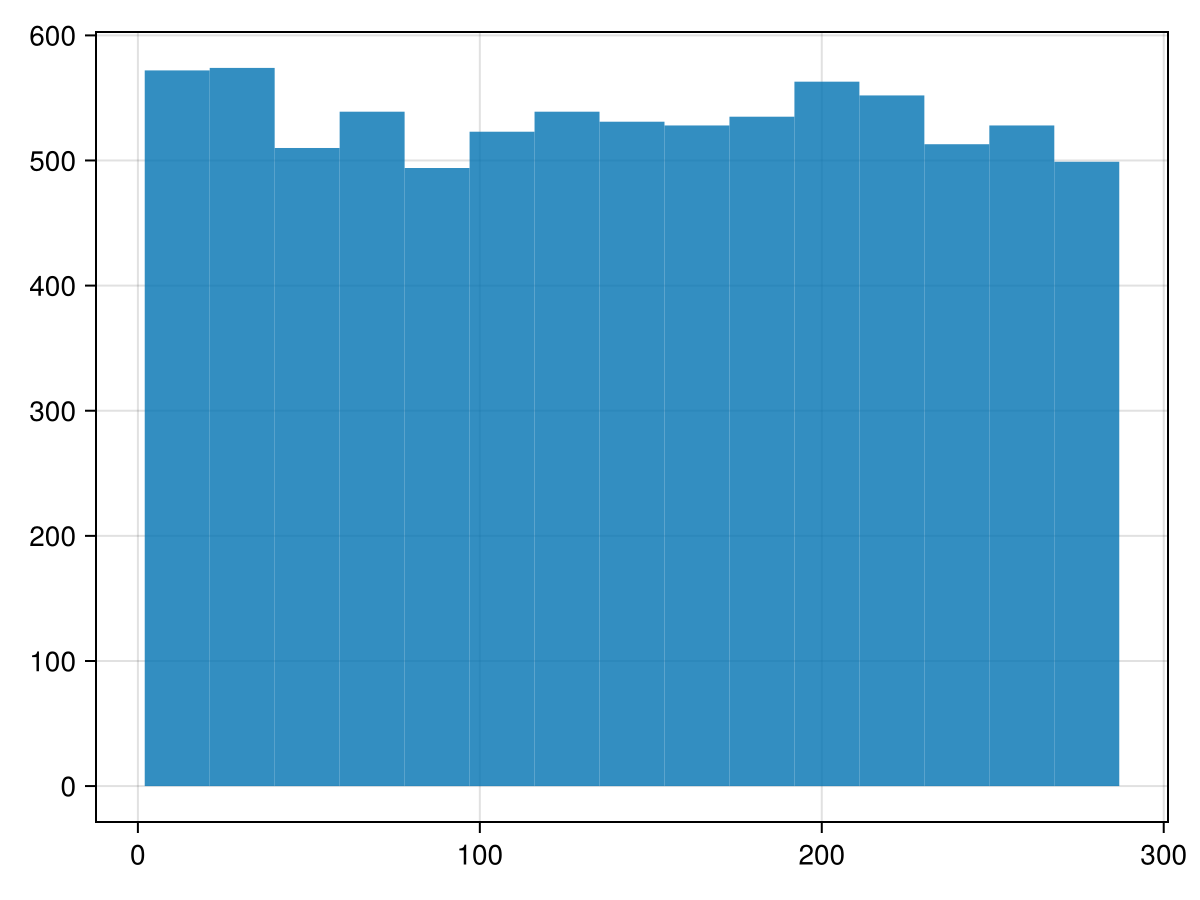

In [131]:
hist(vec(first_gen.midpoints))

In [132]:
sort(rand(DiscreteUniform(1, 286), 9, 9), dims=1)

9×9 Matrix{Int64}:
  40   24   36   28   31   10   25   66   14
  72   30  110   29   44   55   36   76   31
  95   35  111   36   65   64   69  161   68
 107   46  117   94   74  160   74  166   70
 118   78  150   99   86  165  144  178  149
 219   97  195  138   90  170  165  179  171
 252  109  233  151  194  197  190  190  175
 273  139  266  191  206  228  213  204  180
 275  207  270  217  216  238  258  284  263

In [133]:
childrens = AyahMidpoints(copy(first_gen.midpoints))
for generation in 1:generations
    @info "Generation $generation"
    childrens = AyahMidpoints(
        hcat(
            [selection(ayahs_emb, childrens, 3).midpoints for _ in 1:population]...
        )
    )
    crossover!(childrens, 0.8)
    mutate!(childrens, 0.8)
    refine!(childrens)
    @info fitness(
        five_summary(
            gen_slices(ayahs_emb, childrens)
            ), 
        slicer
    ).dist |> mean
end

[ Info: Generation 1


LoadError: ArgumentError: reducing over an empty collection is not allowed; consider supplying `init` to the reducer

In [108]:
childrens

AyahMidpoints{Int64}, 9×1000 Matrix{Int64}:
   7    5    7    5    6    6    6    5  …    4    7    2    2    6    2    2
  13   10   15    8   12   11   13    7      11   14    8    8   11    8   11
  14   14   17   19   14   16   16   13      18   15   16   12   15   11   13
  19   17   18   20   18   20   18   16      19   18   18   19   18   18   20
  20   18   19   21   19   21   19   17      20   19   21   20   19   19   21
  22   22   27   23   20   31   27   18  …   21   20   29   21   21   20   22
  57   62   62   45   47   64   51   66      46   63   55   58   60   69   48
  87   84   94   88   87   95   92   99      89   94   88  106   84   85   89
 122  123  121  111  110  123  115  132     107  119  127  113  122  105  121

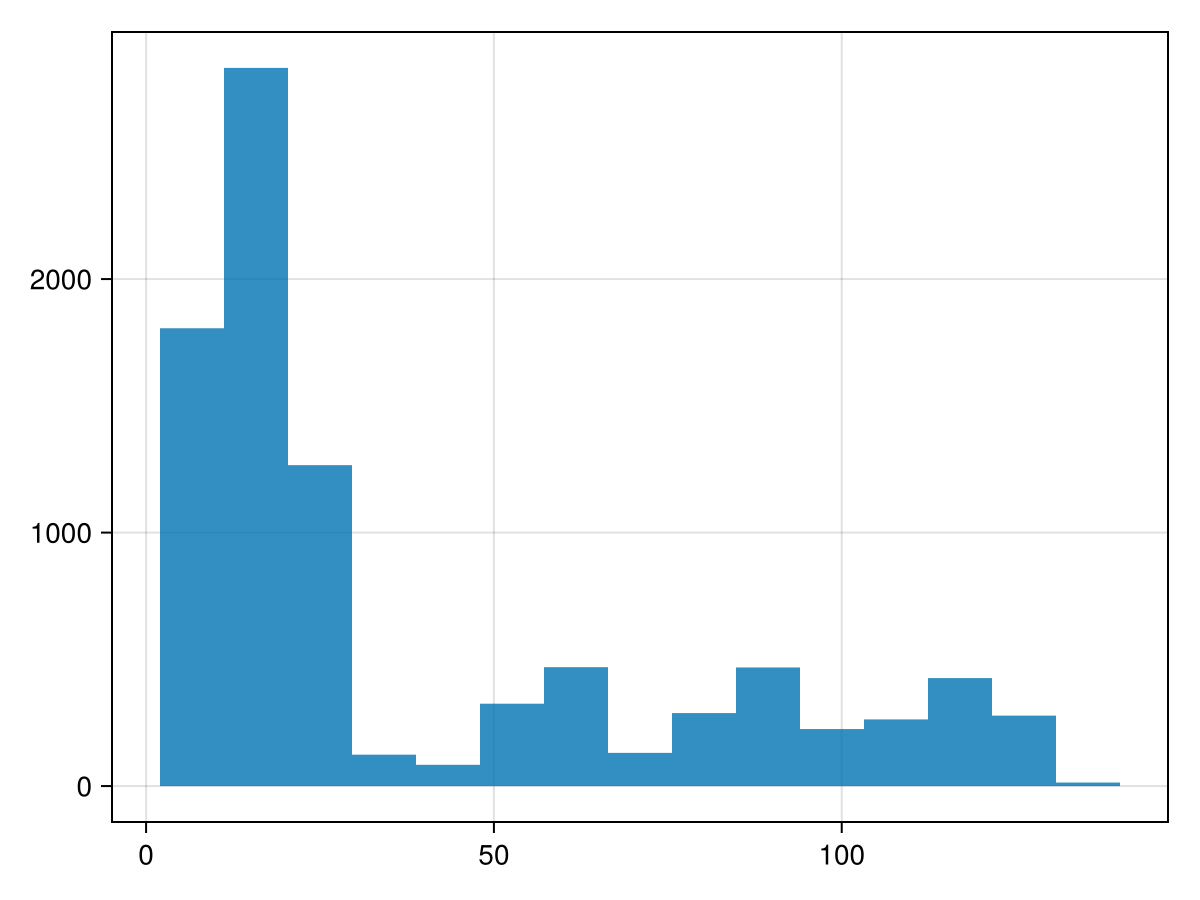

In [109]:
hist(vec(childrens.midpoints))

In [110]:
children_scores = fitness(
    five_summary(
        gen_slices(ayahs_emb, childrens)
        ), 
    slicer
).dist 

1000-element Vector{Float64}:
 -3.167092651128769
 -3.091867446899414
 -4.018972218036652
 -2.6601788997650146
 -4.403760671615601
 -3.086856484413147
 -4.384459733963013
 -2.756562888622284
 -1.1792186349630356
 -3.1663190126419067
 -2.4643517434597015
 -3.1002570390701294
 -3.384040057659149
  ⋮
 -3.322526693344116
 -3.0929200053215027
 -4.396116018295288
 -2.7764695584774017
 -3.0086830258369446
 -3.054956555366516
 -4.163662493228912
 -0.9906852394342422
 -3.0812140107154846
 -4.436249136924744
 -4.081524848937988
 -2.7642232179641724

In [111]:
best_score = children_scores |> (x -> sortperm(x)[1])

710

In [112]:
childrens.midpoints[:, best_score]

9-element Vector{Int64}:
   4
   9
  14
  18
  19
  21
  59
  84
 113